### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import vtk
#from vtk.util import numpy_support as vtk_np
import gc

import sys

#add path
sys.path.insert(0, '../../src/simulator')     # import path/to/synthpy

import beam as beam_initialiser
import domain as d
import propagator as p

import importlib
importlib.reload(beam_initialiser)
importlib.reload(d)
importlib.reload(p)

<module 'propagator' from '/home/administrator/Work/UROP_ICL_Internship/synthPy/examples/notebooks/../../src/simulator/propagator.py'>

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [2]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

n_cells = 128

#x = np.linspace(-extent_x, extent_x, n_cells)
#y = np.linspace(-extent_y, extent_y, n_cells)
#z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

print("Garbage collection count:", gc.collect())

#domain = d.ScalarDomain(x = x, y = y, z = z, extent = probing_extent, probing_direction = probing_direction)     # create domain
# Much simpler domain function, no longer needlessly takes in beam values, they are fully seperated
domain = d.ScalarDomain(lengths, n_cells) # B_on = False by default

# clear we should do manual garbage collection of some variety in d.ScalarDomain function
print("Garbage collection count:", gc.collect())

Garbage collection count: 44
Garbage collection count: 0


Load some domain distribution

In [3]:
# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

#domain.ne = np.full((100, 100, 100), 1e24)
domain.test_exponential_cos()
#domain.test_slab(0.000001, 1e24)

Solve gradients, initialise beam, and solve

In [4]:
lwl = 1064e-9 #define laser wavelength

# initialise beam
Np = 1e5    # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

beam_definition = beam_initialiser.Beam(Np, beam_size, divergence, ne_extent, probing_direction = probing_direction, wavelength = lwl, beam_type = beam_type)

tracer = p.Propagator(domain, beam_definition.s0, probing_direction = probing_direction, inv_brems = False, phaseshift = False, parallelise = True)

# solve ray trace
tracer.calc_dndr(lwl)
# without the _, both rf and Jf (even though it defaults to None when return_E = False) get unpacked into rf and it becomes a tuple
rf, _ = tracer.solve(jitted = True)
print("\nCompleted ray trace in", np.round(tracer.duration, 3), "seconds.")

10000.0

Initialising jax...

Default jax backend: cpu
Available devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15)]

Size in memory of initial rays: 703.25KB
Predicted size in memory of domain: 8.0 MB

Running device: cpu, with: 16 cores.
NamedSharding(mesh=Mesh('cols': 16, axis_types=(Auto,)), spec=PartitionSpec(None, 'cols'), memory_kind=unpinned_host)

jax compilation of solver took: 0.0003933906555175781 seconds


  CPU 0  
  CPU 1  
  CPU 2  
  CPU 3  
  CPU 4  
  CPU 5  
  CPU 6  
  CPU 7  
  CPU 8  
  CPU 9  
 CPU 10  
 CPU 11  
 CPU 12  
 CPU 13  
 CPU 14  
 CPU 15  


Size in memory of initial rays: 712B
Size in memory of solution: 48B
Size in memory of propagator class: 48B

File: ls
Type: space
Showing nodes accounting for 46083.28kB, 100% of 46083.28kB total
Dropped 42 nodes (cum <= 230.42kB)
      flat  flat%   sum%        cum   cum%
35932.12kB 77.97% 77.97% 35932.13kB 77.97%  __call__
 8192.02kB 17.78% 95.75% 18962.17kB 41.15%  apply_primitive
    1250kB  2.71% 98.46%  4414.07kB  9.58%  _pjit_call_impl
  709.12kB  1.54%   100%   709.12kB  1.54%  result_handler
         0     0%   100% 46083.28kB   100%  [ls]
         0     0%   100%  1835.94kB  3.98%  [ls]
         0     0%   100%  8198.03kB 17.79%  __init__
         0     0%   100%  4414.07kB  9.58%  _batch_inner
         0     0%   100%  4414.07kB  9.58%  _batch_outer
         0     0%   100%   709.12kB  1.54%  _batched_device_put_impl
         0     0%   100%  1835.94kB  3.98%  _call
         0     0%   100% 16384.04kB 35.55%  _convert_element_type
         0     0%   100% 16384.04kB 35.55%

Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:


rf size expected: (10000, 10000)
rf after clearing nan's: (8569, 8569)
Garbage collection count: 14


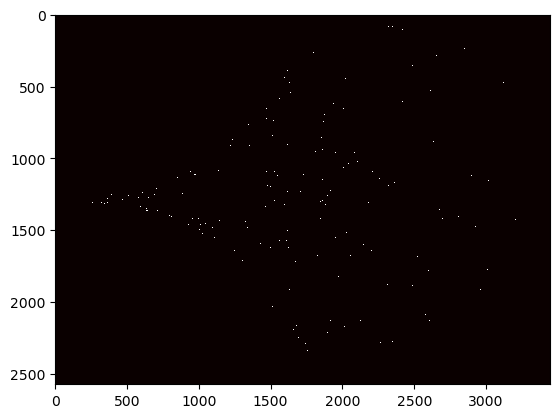

In [5]:
import diagnostics as diag
importlib.reload(diag)
#import utils
#importlib.reload(utils)

#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(lwl, rf)
refractometer.incoherent_solve()
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())


rf size expected: (10000, 10000)
rf after clearing nan's: (8569, 8569)
Garbage collection count: 3160


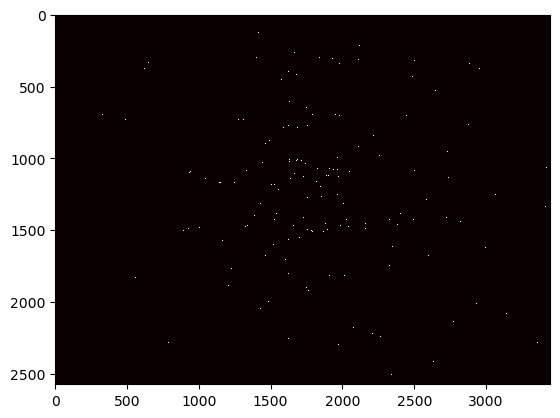

In [6]:
shadowgrapher = diag.Shadowgraphy(lwl, rf)
shadowgrapher.single_lens_solve()
shadowgrapher.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(shadowgrapher.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())


rf size expected: (10000, 10000)
rf after clearing nan's: (6334, 6334)
Garbage collection count: 3139


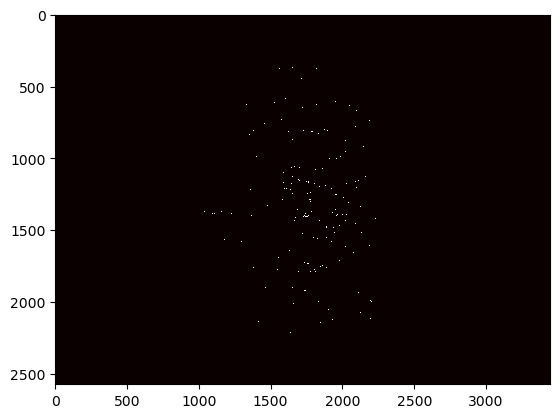

In [7]:
schlierener = diag.Schlieren(lwl, rf)
schlierener.DF_solve()
schlierener.histogram(bin_scale = 1, clear_mem = True)

plt.imshow(schlierener.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())

Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [8]:
# No need to change the domain (now that code has been seperated out in restructure)



# load some external pvti

# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution



# initialise beam



# solve ray trace
tracer = p.Propagator(domain, beam_definition.s0, probing_direction = probing_direction, inv_brems = False, phaseshift = True)

tracer.calc_dndr()
rf, Jf = tracer.solve(parallelise = False, jitted = False, return_E = True)

n_fringes = 10
deg = 10 #adjust number of fringes and tilt in degrees from the vertical exis

interferometrer = diag.Interferometry(lwl, rf, Jf)
interferometrer.interfere_ref_beam(n_fringes, deg)

pattern = diag.Interferometry(lwl, rf, Jf)
#pattern = interferometrer
pattern.two_lens_solve()
pattern.interferogram(bin_scale = 1, clear_mem = True) #use interferogram instead of histogram

#get interferogram histogram with sh.H
plt.imshow(pattern.H, cmap = 'hot', interpolation = 'nearest')


Initialising jax...


AssertionError: jax already imported: you must restart your runtime